# Implémentation du schéma de Rusanov

## Importations

In [ ]:
import math as math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import numpy as np
import imageio

import time

## Paramètres du problème

In [ ]:
g=1 # Constante gravitationnelle

xMin = 0
xMax = 10

N=64
h=(xMax-xMin)/(N+1) # Pas du maillage spatial

Tmax=10 # Temps Max
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

X = np.linspace(xMin,xMax,N+2) # Discrétisation de [xMin, xMax]

# Tableau avec 2 lignes et N+2 colonnes : discrétisation du vecteur (h, q) en N parties + 2 aux bords

U = np.ones((2,N+2))
Uprime = np.zeros((2,N+2)) # Pour faire les calculs dans la boucle

# Topographie Z
Z = 1/(np.exp(X-5)+np.exp(-X+5))
    
def Z_prime(x):
    return 0.5*np.sinh(x-5)/np.cosh(x-5)**2

## Nombre de sauvegardes durant la simulation

In [ ]:
nSauvegarde=100
tSauvegarde=[False for i in range(nSauvegarde)]
images=[]
j=0 #Nombre de sauvegardes déjà effectuées

## Conditions initiales

In [ ]:
U[0,:] = 1/(np.exp(X-2)+np.exp(-X+2))+0.25

## Affichage des images

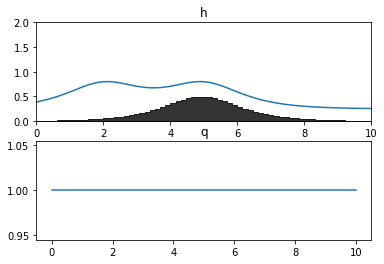

In [ ]:
def affiche_U():
    
    fig, axs = plt.subplots(2,1)
    
    ###
    h_z = [U[0,i]+Z[i] for i in range(N+2)]
    axs[0].plot(X,h_z)
    ###
    
    axs[0].set_title("h")
    axs[0].set_xlim([0,10])
    axs[0].set_ylim([0,2])
    axs[0].fill_between(X, Z, step="pre", alpha=0.8, color="black")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    #axs[1].set_xlim([0,10])
    #axs[1].set_ylim([0,2])
        
    plt.show()
    
affiche_U()

## Sauvegarde des images

In [38]:
def enregistre_U(n,t):

    t=round(t,4) # Troncature de t après la 4eme décimale
    
    fig, axs = plt.subplots(2,1)
    fig.suptitle("t="+str(t),fontsize=16)

    ###
    h_z = [U[0,i]+Z[i] for i in range(N+2)]
    axs[0].plot(X,h_z)
    ###
    
    axs[0].set_title("h")
    axs[0].set_xlim([0,10])
    axs[0].set_ylim([0,2])
    axs[0].fill_between(X, Z , step="pre", alpha=0.8,color="black")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_xlim([0,10])
    axs[1].set_ylim([0,2])
        
    # To remove the huge white borders
    axs[0].margins(0)
    axs[1].margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    images.append(image_from_plot)
    
    #Sauvegarde dans un fichier png
    #plt.savefig("etape"+str(n)+".png")
    
    plt.close()

## Fonctions qui interviennent dans le schéma :

In [ ]:
def F(U):
    """
    """
    return np.array([U[1], U[1]**2/U[0]+g*U[0]**2/2])

def B(U,dxZ):
    """
    """
    return np.array([0, -g*U[0]*dxZ])

def vmax(U,i):
    """
    """
    res = abs(U[1,i]/U[0,i] + math.sqrt(g*U[0,i]))
    
    if (abs(U[1,i]/U[0,i] - math.sqrt(g*U[0,i])) > res):
        res = abs(U[1,i]/U[0,i] - math.sqrt(g*U[0,i]))
        
    if (abs(U[1,i+1]/U[0,i+1] + math.sqrt(g*U[0,i+1])) > res):
        res = abs(U[1,i+1]/U[0,i+1] + math.sqrt(g*U[0,i+1]))
    
    if (abs(U[1,i+1]/U[0,i+1] - math.sqrt(g*U[0,i+1])) > res):
        res = abs(U[1,i+1]/U[0,i+1] - math.sqrt(g*U[0,i+1]))
        
    return res

def F_ronde(U,i):
    """
    """
    return (F(U[:,i])+F(U[:,i+1]))/2-vmax(U,i)*(U[:,i+1]-U[:,i])/2

# Résolution :

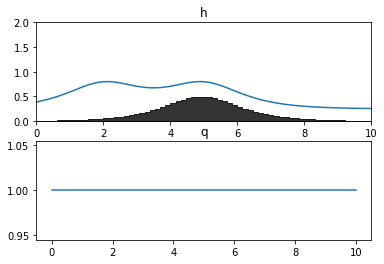

Calcul en cours ...
Nombre d'itérations : 441
Gif Sauvegardé dans le dossier sous le nom : movie.gif


In [40]:
enregistre_U(n,t)
affiche_U()

print("Calcul en cours ...")
while(t<Tmax): # Tant que le temps max n'est pas atteint :

    #print("t="+str(round(t,4)))
    M = vmax(U, 1)
    
    for i in range(2, N+1):
        M = max(M, vmax(U, i))
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = h/(2*M)
    
    for i in range(1, N+1):
        Uprime[0,i] = U[0,i]+tau/h*(F_ronde(U,i-1)-F_ronde(U,i))[0]
        Uprime[1,i] = U[1,i]+tau/h*(F_ronde(U,i-1)-F_ronde(U,i))[1]
        dxZ = Z_prime(X[i])
        Uprime[:,i] += tau*B(U[:,i], dxZ)
        
    U = Uprime
    
    # Conditions aux bords
    U[:,0] = U[:,1]
    U[:,N+1] = U[:,N]

    t+=tau
    n+=1
    
    if (t > Tmax/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        enregistre_U(n,t)
        #affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))

imageio.mimsave('movie.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")